In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import graph
from skimage.segmentation import slic
from scipy.stats import norm
from scipy import sparse
import maxflow
import time

##
## Get User Scribbles (Foreground and Background Labelling)

In [2]:
# Define globals
scribble_mask = []
drawing = False
current_label = 1  # 1 for FG (red), 2 for BG (blue)

In [3]:
def scribble_seeds(event, x, y, flags, param):
    global drawing, current_label, scale_x, scale_y

    img_x = int(x * scale_x)
    img_y = int(y * scale_y)

    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        current_label = 1  # Foreground
    elif event == cv2.EVENT_RBUTTONDOWN:
        drawing = True
        current_label = 2  # Background
    elif event in [cv2.EVENT_LBUTTONUP, cv2.EVENT_RBUTTONUP]:
        drawing = False
    elif event == cv2.EVENT_MOUSEMOVE and drawing:
        if 0 <= img_x < scribble_mask.shape[1] and 0 <= img_y < scribble_mask.shape[0]:
            cv2.circle(scribble_mask, (img_x, img_y), 5, current_label, -1)


def get_user_seeds(image, segments, max_display_size=800):
    '''
    Get initial seeds/inputted foreground and background information from user.
    '''
    global scribble_mask, scale_x, scale_y

    segments = segments.astype(np.int32)
    scribble_mask = np.zeros(image.shape[:2], dtype=np.uint8)

    # Calculate scale for display
    h, w = image.shape[:2]
    scale = min(max_display_size / h, max_display_size / w, 1.0)
    display_size = (int(w * scale), int(h * scale))
    scale_x = w / display_size[0]
    scale_y = h / display_size[1]

    cv2.namedWindow("Scribble on Image", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("Scribble on Image", *display_size)
    cv2.setMouseCallback("Scribble on Image", scribble_seeds)

    while True:
        overlay = image.copy()
        overlay[scribble_mask == 1] = [0, 0, 255]   # Red for foreground
        overlay[scribble_mask == 2] = [255, 0, 0]   # Blue for background
        overlay_resized = cv2.resize(overlay, display_size, interpolation=cv2.INTER_NEAREST)

        cv2.imshow("Scribble on Image", overlay_resized)
        key = cv2.waitKey(1)
        if key == 13: # Enter Key
            break

    cv2.destroyAllWindows()

    fg_seeds = set(np.unique(segments[scribble_mask == 1]))
    bg_seeds = set(np.unique(segments[scribble_mask == 2]))
    fg_seeds.discard(0)
    bg_seeds.discard(0)

    return fg_seeds, bg_seeds

##
## Create Graph 

In [6]:
def superpixel_segmentation(image):
    '''
    Apply low level segmentation to reduce computational costs. 
    Use superpixel segmentation instead of EDISON mean shift for better 
    implementation in Python.
    '''
    return slic(image, n_segments=500, compactness=10)

def compute_gaussian_likelihoods(image, segments, fg_seeds, bg_seeds):
    '''
    Computes per-pixel probability of belonging to foreground or background
    using a fixed Gaussian model from user scribbles.
    Calculates the likelihoods using SciPy's norm function.
    Used for the data term estimation.
    '''
    fg_pixels = np.vstack([
        image[segments == s] for s in fg_seeds if np.any(segments == s)
    ])
    bg_pixels = np.vstack([
        image[segments == s] for s in bg_seeds if np.any(segments == s)
    ])

    print("[compute_GMM_likelihood] Computing likelihoods...")

    # Compute mean and std for each channel
    fg_mean, fg_std = fg_pixels.mean(axis=0), fg_pixels.std(axis=0) + 1e-5
    bg_mean, bg_std = bg_pixels.mean(axis=0), bg_pixels.std(axis=0) + 1e-5

    # Now compute likelihoods for each segment
    segment_ids = np.unique(segments)
    fg_likelihoods, bg_likelihoods = {}, {}

    for s in segment_ids:
        pix = image[segments == s]
        fg_prob = norm.pdf(pix, loc=fg_mean, scale=fg_std).prod(axis=1).mean()
        bg_prob = norm.pdf(pix, loc=bg_mean, scale=bg_std).prod(axis=1).mean()
        fg_likelihoods[s] = fg_prob
        bg_likelihoods[s] = bg_prob

    print("[compute_GMM_likelihood] Done.")
    return fg_likelihoods, bg_likelihoods

def compute_segment_means(image, segments, n_segments):
    '''
    Compute mean color per segment for smoothness (N-links)
    '''
    segment_means = np.zeros((n_segments, 3))
    for i in range(n_segments):
        mask = (segments == i)
        if np.any(mask):
            segment_means[i] = np.mean(image[mask], axis=0)
    return segment_means

def build_RAG(segments):
    '''
    Build a set of edges (segment pairs that are neighbors).
    '''
    H, W = segments.shape
    edges = set()
    for y in range(H - 1):
        for x in range(W - 1):
            node = segments[y, x]
            # Only consider neighboring pixels to the right and below
            # The others are already considered in earlier scans
            node_right = segments[y, x + 1]
            node_below = segments[y + 1, x]
            #  Only take in nodes of differently-labeled segments
            if node != node_right:
                edges.add(tuple(sorted((node, node_right))))
            if node != node_below:
                edges.add(tuple(sorted((node, node_below))))
    print(f"[build_RAG] Built RAG with {len(edges)} edges.")
    return edges

def add_n_links(graph, edges, segment_means, sigma_sq=1000, lambda_val=100):
    '''
    Add n-link weights based on color similarity between neighbors.
    This defines the smoothness term for the energy function.
    - Weight is calculated using a Gaussian function.
    - Hard-coded lambda value is 100.
    '''
    for u, v in edges:
        u_idx = segment_means[u] + 1  # Shift by 1 (0 = source)
        v_idx = segment_means[v] + 1  # Shift by 1 (N+1 = sink)
        color_diff = np.linalg.norm(segment_means[u] - segment_means[v])
        weight = lambda_val * np.exp(-color_diff**2 / (2 * sigma_sq))
        weight = max(1, int(weight))
        graph[u_idx, v_idx] = weight
        graph[v_idx, u_idx] = weight
    return graph

def add_t_links(graph, fg_seeds, bg_seeds, fg_likelihoods, bg_likelihoods):
    '''
    Connect each segment to source/sink using hard or soft GMM constraints.
    This defines the data term for the energy function using GMM log-likelihoods.
    Node indices:
        0       -> source
        1..N    -> segments
        N+1     -> sink
    '''
    n_segments = len(fg_likelihoods)
    source_idx = 0
    sink_idx = n_segments + 1
    
    for s in range(n_segments):
        if s in fg_seeds:
            graph[source_idx, s + 1] = 1000 # hard constraint to foreground
            graph[s + 1, source_idx] = 1000
            graph[s + 1, sink_idx] = 0      # set no connection to sink
            graph[sink_idx, s + 1] = 0
        elif s in bg_seeds:
            graph[s + 1, sink_idx] = 1000   # hard constraint to background
            graph[sink_idx, s + 1] = 1000
            graph[source_idx, s + 1] = 0    # set no connection to source
            graph[s + 1, source_idx] = 0
        else:
            fg_cost = -np.log(fg_likelihoods[s] + 1e-10)
            bg_cost = -np.log(bg_likelihoods[s] + 1e-10)
            graph[source_idx, s + 1] = fg_cost
            graph[s + 1, source_idx] = fg_cost
            graph[s + 1, sink_idx] = bg_cost
            graph[sink_idx, s + 1] = bg_cost
    return graph

##
## Peng's Algorithm Implementation

In [18]:
def get_neighbors(segments, seed_segments):
    '''
    Given segment labels (segments) and a set of seed segment indices,
    return the set of neighbors of these seeds.
    '''
    H, W = segments.shape
    neighbors = set()
    for y in range(H - 1):
        for x in range(W - 1):
            s = segments[y, x]
            right = segments[y, x + 1]
            down = segments[y + 1, x]

            # Get neighbors, avoid neighbors already in the set
            if s in seed_segments and right not in seed_segments and s != right:
                neighbors.add(right)
            if s in seed_segments and down not in seed_segments and s != down:
                neighbors.add(down)
            if right in seed_segments and s not in seed_segments and s != right:
                neighbors.add(s)
            if down in seed_segments and s not in seed_segments and s != down:
                neighbors.add(s)
    return neighbors

def build_subgraph(image, segments, fg_seeds, bg_seeds, sigma_sq=1000):
    '''
    Builds a graph for the subgraph containing seeds + their neighbors,
    with edges weighted by GMM likelihoods and color similarity.
    '''
    # Define subgraph region
    seed_set = fg_seeds.union(bg_seeds)
    subgraph_nodes = seed_set.union(get_neighbors(segments, seed_set))
    subgraph_nodes = sorted(list(subgraph_nodes))

    print(f"[build_subgraph] Subgraph includes {len(subgraph_nodes)} nodes.")

    # Maps segment labels to their respective subgraph indexes
    seg_to_sub = {seg: idx for idx, seg in enumerate(subgraph_nodes)}

    # Restrict seeds to those actually in the subgraph
    fg_sub_seeds = fg_seeds.intersection(subgraph_nodes)
    bg_sub_seeds = bg_seeds.intersection(subgraph_nodes)

    print(f"[build_subgraph] Subgraph FG seeds: {len(fg_sub_seeds)}, BG seeds: {len(bg_sub_seeds)}")

    # Compute the data term
    fg_likelihoods, bg_likelihoods = compute_gaussian_likelihoods(image, segments, fg_sub_seeds, bg_sub_seeds)

    # Keep only likelihoods for subgraph nodes in order
    fg_likelihoods_sub = np.array([fg_likelihoods[s] for s in subgraph_nodes])
    bg_likelihoods_sub = np.array([bg_likelihoods[s] for s in subgraph_nodes])

    segment_means = compute_segment_means(image, segments, np.max(segments) + 1)

    full_edges = build_RAG(segments)
    edges = [(u, v) for u, v in full_edges if u in subgraph_nodes and v in subgraph_nodes]

    print(f"[build_subgraph] Filtered to {len(edges)} subgraph edges.")

    n_sub = len(subgraph_nodes)
    graph = sparse.lil_matrix((n_sub + 2, n_sub + 2))

    graph = add_n_links(graph, edges, seg_to_sub, sigma_sq)
    graph = add_t_links(graph, fg_sub_seeds, bg_sub_seeds, fg_likelihoods_sub, bg_likelihoods_sub)

    print("[build_subgraph] Subgraph construction complete.")
    return graph, subgraph_nodes

def run_graph_cut(graph):
    '''
    Runs maxflow/mincut using PyMaxflow on the constructed sparse graph.
    Returns a list of labels (1=foreground, 0=background) for all non-terminal nodes.
    Uses maxflow from PyMaxflow that implements the Boykov-Kolmogorov Algorithm.
    '''
    print("[run_graph_cut] Running maxflow...")
    g = maxflow.Graph[float](graph.shape[0], graph.getnnz())
    nodes = g.add_nodes(graph.shape[0])

    # Add edges (undirected)
    rows, cols = graph.nonzero()

    for u, v in zip(rows, cols):                 # For every valid edge (u, v) 
        capacity = graph[u, v]                   # extract weight
        if capacity > 0:                         # for non-zero weights in edges
            g.add_edge(u, v, capacity, capacity) # add as bidirectional flow with same weight

    source = 0
    sink = graph.shape[0] - 1

    # Computes maxflow/mincut
    flow = g.maxflow()

    print(f"[run_graph_cut] Maxflow computed: {flow}")
    
    # Gets labels (0 or 1) of non-terminal nodes
    labels = [g.get_segment(i) for i in range(1, sink)]  # skip terminals

    return labels

def update_global_seeds(labels_subgraph, subgraph_nodes, fg_seeds, bg_seeds, initial_fg_seeds, initial_bg_seeds):
    '''
    Update the global FG and BG seed sets based on the subgraph segmentation result,
    but **never remove the initial user seeds** once added.
    '''
    print("[update_global_seeds] Updating global seeds...")

    for seg_idx, label in zip(subgraph_nodes, labels_subgraph):
        if label == 1:
            fg_seeds.add(seg_idx)
            # Only discard from background if NOT an initial background seed
            if seg_idx not in initial_bg_seeds:
                bg_seeds.discard(seg_idx)
        else:
            bg_seeds.add(seg_idx)
            # Only discard from foreground if NOT an initial foreground seed
            if seg_idx not in initial_fg_seeds:
                fg_seeds.discard(seg_idx)

    # Always keep initial seeds no matter what:
    fg_seeds.update(initial_fg_seeds)
    bg_seeds.update(initial_bg_seeds)

    print(f"[update_global_seeds] Total FG: {len(fg_seeds)}, BG: {len(bg_seeds)}")
    return fg_seeds, bg_seeds

def iterative_graph_cut(image, segments, initial_fg_seeds, initial_bg_seeds,
                        sigma_sq=1000, max_iters=10):
    '''
    Implements Peng et al.'s iterative graph cut algorithm using superpixel segments.
    Args:
        image: (H, W, 3) input image
        segments: (H, W) segment labels from superpixel
        initial_fg_seeds: set of foreground seed segment labels
        initial_bg_seeds: set of background seed segment labels
        sigma_sq: float, smoothness parameter
        max_iters: max number of iterations to prevent infinite loop
    Returns:
        fg_seeds, bg_seeds: final sets of foreground and background segments
    '''
    fg_seeds = set(initial_fg_seeds)
    bg_seeds = set(initial_bg_seeds)

    previous_seed_count = 0

    print(f"[iterative_graph_cut] Starting iterations with {max_iters} max iterations.")
    
    for i in range(max_iters):
        print(f"Iteration {i + 1}")

        # Build subgraph around current seeds (foreground + background neighbors)
        graph, subgraph_nodes = build_subgraph(
            image, segments, fg_seeds, bg_seeds, sigma_sq,
        )

        # Run graph cut on subgraph
        labels_subgraph = run_graph_cut(graph)

        # Update global seeds based on graph cut result
        fg_seeds, bg_seeds = update_global_seeds(
            labels_subgraph, subgraph_nodes, fg_seeds, bg_seeds, 
            initial_fg_seeds, initial_bg_seeds)

        current_seed_count = len(fg_seeds) + len(bg_seeds)

        # Early stop if no new seeds added
        if current_seed_count == previous_seed_count:
            print("[iterative_graph_cut] No new seeds added. Stopping early.")
            break
        previous_seed_count = current_seed_count

    # After iteration, label all segments not in fg or bg seeds as background
    all_segments = set(range(np.max(segments) + 1))
    unlabeled = all_segments - fg_seeds - bg_seeds
    bg_seeds.update(unlabeled)
    print("[iterative_graph_cut] Iteration complete.")

    return fg_seeds, bg_seeds

In [9]:
def create_foreground_mask(segments, fg_seeds):
    """
    Create a binary mask where pixels belonging to foreground segments are 1, else 0.

    Args:
        segments (H, W): segment labels image
        fg_seeds (set): set of segment labels classified as foreground

    Returns:
        mask (H, W): binary mask, dtype=np.uint8, 1 for foreground pixels, 0 for background
    """
    mask = np.zeros(segments.shape, dtype=np.uint8)
    
    # Create a boolean mask where pixels belong to any fg segment
    fg_mask = np.isin(segments, list(fg_seeds))
    
    mask[fg_mask] = 1  # or 255 if you want a mask for visualization
    
    return mask

##
## Main Program

In [10]:
image = cv2.imread("../images/clay.png")

start_time = time.time()
segments = superpixel_segmentation(image)
end_time = time.time()
elapsed = end_time - start_time
print(f"Function took {elapsed:.4f} seconds")

Function took 3.6368 seconds


In [21]:
print(len(np.unique(segments)))

313


In [19]:
initial_fg_seeds, initial_bg_seeds = get_user_seeds(image, segments)

In [20]:
start_time = time.time()
fg_seeds, bg_seeds = iterative_graph_cut(image, segments, initial_fg_seeds, initial_bg_seeds)
end_time = time.time()
elapsed = end_time - start_time
print(f"Function took {elapsed:.4f} seconds.")

[iterative_graph_cut] Starting iterations with 10 max iterations.
Iteration 1
[build_subgraph] Subgraph includes 134 nodes.
[build_subgraph] Subgraph FG seeds: 31, BG seeds: 27
[compute_GMM_likelihood] Computing likelihoods...
[compute_GMM_likelihood] Done.
[build_RAG] Built RAG with 856 edges.
[build_subgraph] Filtered to 351 subgraph edges.
[build_subgraph] Subgraph construction complete.
[run_graph_cut] Running maxflow...
[run_graph_cut] Maxflow computed: 0.0
[update_global_seeds] Updating global seeds...
[update_global_seeds] Total FG: 31, BG: 134
Iteration 2
[build_subgraph] Subgraph includes 173 nodes.
[build_subgraph] Subgraph FG seeds: 31, BG seeds: 134
[compute_GMM_likelihood] Computing likelihoods...
[compute_GMM_likelihood] Done.
[build_RAG] Built RAG with 856 edges.
[build_subgraph] Filtered to 462 subgraph edges.
[build_subgraph] Subgraph construction complete.
[run_graph_cut] Running maxflow...
[run_graph_cut] Maxflow computed: 0.0
[update_global_seeds] Updating global se

In [25]:
fg_mask = create_foreground_mask(segments, fg_seeds)
segmented = image * fg_mask[:, :, np.newaxis]

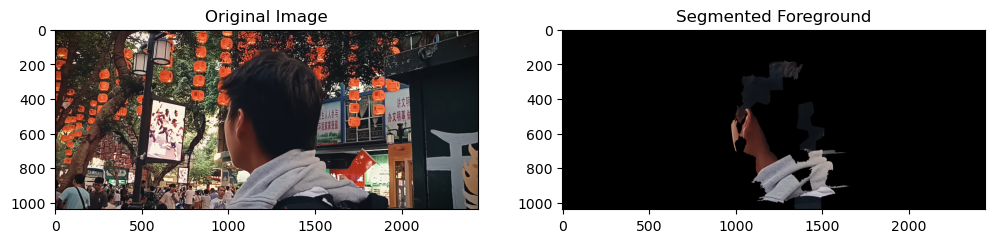

In [33]:
plt.figure(figsize=(12, 6))
plt.subplot(121); plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)); plt.title('Original Image')
plt.subplot(122); plt.imshow(cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB)); plt.title('Segmented Foreground')
plt.show()